In [203]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import math
import shutil
import tqdm
import time

In [204]:
CENTER = (int(2160/2)+100,1950)
CENTER_CV = (CENTER[1],CENTER[0])
HEIGHT = 2160
WIDTH = 3840
REFERENCES = [0, 32]
HIRE_DICT = {
    16: 16,
    8:8,
    4:4,
    2:2,
    1:1,
    3:1,
    6:2,
    5:1,
    7:1,
    12:4,
    10:2,
    9:1,
    11:1,
    14:2,
    13:1,
    15:1,
    24:8,
    20:4,
    18:2,
    17:1,
    19:1,
    22:2,
    21:1,
    23:1,
    28:4,
    26:2,
    25:1,
    27:1,
    30:2,
    29:1,
    31:1
}

sift_points_num_dict = {
    16:500,
    8:500,
    4:500,
    2:500,
    1:500,
}
static_H = np.diag((1.0,1.0,1.0))

In [205]:
def domask(reference, mask):
    masked_image = np.zeros_like(reference)
    masked_image[mask] = reference[mask]
    return masked_image
    
# def ray_mask(img, mask, direction = 'backward', distance_rate=1):
#     points = get_ray_points(mask,direction,distance_rate=distance_rate)
#     mask2 = np.zeros_like(img)
#     hull = cv2.convexHull(np.array(points))
#     cv2.fillConvexPoly(mask2, hull, (255))
#     masked_image = cv2.bitwise_and(img, mask2)
#     return masked_image

def ray_mask(img, mask, direction = 'backward', frame_diff=16, kernel_size = (25,25)):
    if frame_diff <= 4:
        frame_diff = 4
    if direction == 'forward':
        frame_diff = int(frame_diff*1.5)
    """find a bigger mask that may contain ROI by simply do dilation"""
    kernel = np.ones(kernel_size,np.uint8)
    mask = cv2.dilate(mask.astype('uint8')*255,kernel,iterations = frame_diff)
    masked_image = cv2.bitwise_and(img, mask)
    return mask, masked_image

In [206]:
def to_000(number):
    return f"000{str(number)}"[-3:]

def fill_black(img_to_fill, img2):
    """fill black pixels in img_to_fill with some point on img2"""
    mask = (img_to_fill == 0)
    img_to_fill[mask] = img2[mask]
    return img_to_fill

In [207]:
sift_cahce = {}
def get_cache_sift(frame_num, mask):
    """From the cached SIFT result, get point inside the mask. If no cache found, calculate and save"""
    global sift_cahce
    frame_num = to_000(frame_num)
    if frame_num in sift_cahce.keys():
        kp, des = sift_cahce[frame_num]
    else:
        img = cv2.imread(f"frame/{frame_num}.png", cv2.IMREAD_GRAYSCALE)
        sift = cv2.SIFT_create()
        # find the keypoints and descriptors with SIFT
        kp, des =  sift.detectAndCompute(img,None)
        sift_cahce[frame_num] =[kp, des]
    return filter_keypoints_with_mask(kp, des,mask)

def filter_keypoints_with_mask(kp, des, mask):
    """
    Filters keypoints that are within the given binary mask. return 

    :param keypoints: List of keypoints (list of cv2.KeyPoint or list of tuples with coordinates)
    :param mask: Binary mask image (numpy array)
    :return: List of filtered keypoints within the mask
    """
    filtered_kp = []
    filtered_des = []
    for i, keypoint in enumerate(kp):
        # If keypoints are in cv2.KeyPoint format, get their coordinates
        if isinstance(keypoint, cv2.KeyPoint):
            pt = (int(keypoint.pt[0]), int(keypoint.pt[1]))
        else:
            pt = (int(keypoint[0]), int(keypoint[1]))
        # Check if the point is within the mask
        if mask[pt[1], pt[0]] > 0:
            filtered_kp.append(kp[i])
            filtered_des.append(des[i])
    return filtered_kp, np.array(filtered_des)

In [208]:
class Stitcher:
    def __init__(self, target_num ='016' ,frame_diff = 16 , mask = "mask_general.npy"):
        target_num =to_000(target_num)
        self.target = cv2.imread(f"frame/{target_num}.png",cv2.IMREAD_GRAYSCALE)
        self.target_num = target_num
        self.frame_diff = frame_diff
        self.reference_nums = [to_000(int(target_num)-frame_diff),to_000(int(target_num)+frame_diff) ]
        self.reference1 = cv2.imread(f"frame/{self.reference_nums[0]}.png",cv2.IMREAD_GRAYSCALE)
        self.reference2 = cv2.imread(f"frame/{self.reference_nums[1]}.png",cv2.IMREAD_GRAYSCALE)
        self.totalmask = np.load(mask)
        self.labelnum = (self.totalmask.max())+1
        self.canvas = np.zeros_like(self.target)
        self.warpdict = {}

    def search(self, target_mask, direction='backward'):
        if direction == "backward":
            reference_num = self.reference_nums[0]
            reference= self.reference1 
        else:
            reference_num = self.reference_nums[1]
            reference= self.reference2
        reference_mask, reference_masked =ray_mask(reference,self.mask, direction=direction, frame_diff=self.frame_diff)
        H = self.detect_march_findH(target_mask, reference_mask, reference_num)
        return H, reference_masked

    def detect_march_findH(self, target_mask, reference_mask, reference_num):
        src_pts, dst_pts, match_count = self.sift_match(target_mask, reference_mask, reference_num)
        if match_count < 4:
            # self.drawMatches([reference_masked, target_masked], matches)
            print("no enough matched points to find H")
            return None
        else:
            H = self.fitHomoMat(src_pts, dst_pts)
            return H    
    def sift_match(self, target_mask, reference_mask, reference_num):
        # find the keypoints and descriptors with SIFT
        kp1, des1 = get_cache_sift(self.target_num, target_mask)
        kp2, des2 = get_cache_sift(reference_num, reference_mask)
        
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1,des2,k=2)
        
        # store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.4*n.distance: # the number was originally 0.7, but I need it strict
                good.append(m)
            
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        return src_pts, dst_pts, len(good)

    def stitch(self, label):
        '''
            Match points and find H and store in dict, label-wise
        '''
        # Step0 - mask
        self.mask =  (self.totalmask == label)
        target_mask = self.mask
        self.warpdict[label]= {}
        if self.mask.sum() == 0:
            return
        
        if label == 8: # the lower static part do directly paste
            self.warpdict[label]['backward'] = {'available': True,"H":static_H, 'mask': self.mask, 'reference_num':self.reference_nums[0], 'reference':domask(self.reference1, self.mask)}
            self.warpdict[label]['forward'] = {'available': True,"H":static_H, 'mask': self.mask, 'reference_num':self.reference_nums[1], 'reference':domask(self.reference1, self.mask)}
            return self.warpdict[label]
        if label ==0:
            self.warpdict[label]['backward'] = {'available': False,"H":static_H, 'mask': self.mask, 'reference_num':self.reference_nums[0], 'reference':domask(self.reference1, self.mask)}
            self.warpdict[label]['forward'] = {'available': False,"H":static_H, 'mask': self.mask, 'reference_num':self.reference_nums[1], 'reference':domask(self.reference1, self.mask)}
            return self.warpdict[label]

        # target_masked =domask(self.target, self.mask)

        forward_H, forward_reference_masked = self.search(target_mask, direction= 'forward')
        backward_H, backward_reference_masked = self.search(target_mask, direction= 'backward')

        if isinstance(forward_H, np.ndarray):
            self.warpdict[label]['forward'] = {'available': True,"H":forward_H, 'mask': self.mask, 'reference_num':self.reference_nums[1], 'reference':forward_reference_masked}
        else:
            self.warpdict[label]['forward'] ={'available': False ,"H":forward_H, 'mask': self.mask, 'reference_num':self.reference_nums[1], 'reference':forward_reference_masked}
        
        if isinstance(backward_H, np.ndarray):
            self.warpdict[label]['backward'] = {'available': True,"H":backward_H, 'mask': self.mask, 'reference_num':self.reference_nums[0], 'reference':backward_reference_masked}
        else:
            self.warpdict[label]['backward'] ={'available': False ,"H":backward_H, 'mask': self.mask, 'reference_num':self.reference_nums[0], 'reference':backward_reference_masked}
        return self.warpdict[label]
    
    def warp_and_paste(self):
        for label in self.warpdict.keys():
            if label == 0:
                if self.warpdict[1]['backward']['available'] == True:
                    self.warpdict[0]['backward']['H'] =  self.warpdict[1]['backward']['H'] 
                    self.warpdict[0]['backward']['available'] =  self.warpdict[1]['backward']['available'] 
                if self.warpdict[1]['forward']['available'] == True:
                    self.warpdict[0]['forward']['H'] =  self.warpdict[1]['forward']['H'] 
                    self.warpdict[0]['forward']['available'] =  self.warpdict[1]['forward']['available'] 
            current_warpdict = self.warpdict[label]
            mask = current_warpdict['backward']['mask']
            warped_imgs = self.warp(current_warpdict)
            if not bool(warped_imgs):
                continue
            warp_img = self.linear_blending(warped_imgs, current_warpdict, mask)
            self.canvas[mask] = warp_img[mask]
        return self.canvas
    
    def cal_alpha(self, images1, images2):
        """set alpha weight based on image pixel diversity?"""
        alpha = 0.5
        beta = (1.0 - alpha)
        return alpha, beta
        
    def linear_blending(self, images, warpdict, mask):
        if len(images) == 1:
            return domask(images[0], mask)
        images[0] = fill_black(images[0], images[1])
        images[1] = fill_black(images[1], images[0])
        alpha, beta = self.cal_alpha(images[0], images[1])
        dst = cv2.addWeighted(images[0], alpha, images[1], beta, 0.0)
        return domask(dst, mask)
    
    def fitHomoMat(self, srcPoints, dstPoints):
        '''
            Fit the best homography model with RANSAC algorithm - noBlending、linearBlending、linearBlendingWithConstant
        '''
        H, _ = cv2.findHomography(srcPoints, dstPoints, cv2.RANSAC, 5.0)
        if not isinstance(H, np.ndarray):
            H, _ = cv2.findHomography(srcPoints, dstPoints, method=0)
        return H
    
    def warp(self, warpdict):
        '''
        Return a pair of warped image 
        '''
        b_dict = warpdict['backward']
        f_dict = warpdict['forward']
        result = []
        if b_dict['available']:
            result.append(cv2.warpPerspective(b_dict['reference'], b_dict['H'], ( WIDTH, HEIGHT,)))
        if f_dict['available']:
            result.append(cv2.warpPerspective(f_dict['reference'], f_dict['H'], ( WIDTH, HEIGHT,), flags = cv2.WARP_INVERSE_MAP))
        return result

In [209]:
def to32(num):
    while num > 32:
        num -= 32
    return num

In [210]:
# main
if not os.path.exists('results'):
    os.mkdir('results')

for i in tqdm.tqdm(range(129)):
    if to32(i) in REFERENCES:
        print(f"copy {to_000(i)}.png")
        shutil.copyfile(f"frame/{to_000(i)}.png", f"results/{to_000(i)}.png")
        continue
    print(f"generating {to_000(i)}.png with frame_diff {HIRE_DICT[to32(i)]}")
    stitcher = Stitcher(target_num =i ,frame_diff = HIRE_DICT[to32(i)],mask = "mask_general.npy")
    for j in range(stitcher.labelnum):
        stitcher.stitch(j)
    result = stitcher.warp_and_paste()
    cv2.imwrite(f"results/{to_000(i)}.png", result)

  0%|          | 0/129 [00:00<?, ?it/s]

copy 000.png
generating 001.png with frame_diff 1


  2%|▏         | 2/129 [00:06<06:38,  3.13s/it]

generating 002.png with frame_diff 2


  2%|▏         | 3/129 [00:09<06:51,  3.26s/it]

generating 003.png with frame_diff 1


  3%|▎         | 4/129 [00:13<07:09,  3.43s/it]

generating 004.png with frame_diff 4


  4%|▍         | 5/129 [00:17<07:29,  3.62s/it]

generating 005.png with frame_diff 1


  5%|▍         | 6/129 [00:22<08:10,  3.99s/it]

generating 006.png with frame_diff 2


  5%|▌         | 7/129 [00:24<06:54,  3.40s/it]

generating 007.png with frame_diff 1


  6%|▌         | 8/129 [00:27<06:51,  3.40s/it]

generating 008.png with frame_diff 8


  7%|▋         | 9/129 [00:31<07:07,  3.56s/it]

generating 009.png with frame_diff 1


  8%|▊         | 10/129 [00:36<07:52,  3.97s/it]

generating 010.png with frame_diff 2


  9%|▊         | 11/129 [00:40<07:43,  3.92s/it]

generating 011.png with frame_diff 1


  9%|▉         | 12/129 [00:43<07:29,  3.84s/it]

generating 012.png with frame_diff 4


 10%|█         | 13/129 [00:46<06:29,  3.36s/it]

generating 013.png with frame_diff 1


 11%|█         | 14/129 [00:51<07:23,  3.85s/it]

generating 014.png with frame_diff 2


 12%|█▏        | 15/129 [00:53<06:27,  3.40s/it]

generating 015.png with frame_diff 1


 12%|█▏        | 16/129 [00:57<06:32,  3.48s/it]

generating 016.png with frame_diff 16


 13%|█▎        | 17/129 [01:02<07:21,  3.94s/it]

generating 017.png with frame_diff 1


 14%|█▍        | 18/129 [01:07<07:45,  4.20s/it]

generating 018.png with frame_diff 2


 15%|█▍        | 19/129 [01:11<07:34,  4.13s/it]

generating 019.png with frame_diff 1


 16%|█▌        | 20/129 [01:14<07:21,  4.05s/it]

generating 020.png with frame_diff 4


 16%|█▋        | 21/129 [01:18<07:09,  3.98s/it]

generating 021.png with frame_diff 1


 17%|█▋        | 22/129 [01:23<07:47,  4.37s/it]

generating 022.png with frame_diff 2


 18%|█▊        | 23/129 [01:26<06:35,  3.73s/it]

generating 023.png with frame_diff 1


 19%|█▊        | 24/129 [01:29<06:23,  3.65s/it]

generating 024.png with frame_diff 8


 19%|█▉        | 25/129 [01:32<05:44,  3.31s/it]

generating 025.png with frame_diff 1


 20%|██        | 26/129 [01:37<06:27,  3.76s/it]

generating 026.png with frame_diff 2


 21%|██        | 27/129 [01:40<06:20,  3.73s/it]

generating 027.png with frame_diff 1


 22%|██▏       | 28/129 [01:44<06:10,  3.67s/it]

generating 028.png with frame_diff 4


 22%|██▏       | 29/129 [01:46<05:25,  3.26s/it]

generating 029.png with frame_diff 1


 23%|██▎       | 30/129 [01:51<06:05,  3.70s/it]

generating 030.png with frame_diff 2


 24%|██▍       | 31/129 [01:53<05:18,  3.25s/it]

generating 031.png with frame_diff 1


 25%|██▍       | 32/129 [01:57<05:28,  3.39s/it]

copy 032.png
generating 033.png with frame_diff 1


 26%|██▋       | 34/129 [02:02<04:47,  3.02s/it]

generating 034.png with frame_diff 2


 27%|██▋       | 35/129 [02:06<05:01,  3.21s/it]

generating 035.png with frame_diff 1


 28%|██▊       | 36/129 [02:09<05:03,  3.26s/it]

generating 036.png with frame_diff 4


 29%|██▊       | 37/129 [02:13<05:14,  3.42s/it]

generating 037.png with frame_diff 1


 29%|██▉       | 38/129 [02:18<05:51,  3.86s/it]

generating 038.png with frame_diff 2


 30%|███       | 39/129 [02:20<05:05,  3.39s/it]

generating 039.png with frame_diff 1


 31%|███       | 40/129 [02:24<05:06,  3.45s/it]

generating 040.png with frame_diff 8


 32%|███▏      | 41/129 [02:28<05:22,  3.66s/it]

generating 041.png with frame_diff 1


 33%|███▎      | 42/129 [02:33<05:54,  4.07s/it]

generating 042.png with frame_diff 2


 33%|███▎      | 43/129 [02:37<05:40,  3.95s/it]

generating 043.png with frame_diff 1


 34%|███▍      | 44/129 [02:40<05:31,  3.90s/it]

generating 044.png with frame_diff 4


 35%|███▍      | 45/129 [02:43<04:58,  3.55s/it]

generating 045.png with frame_diff 1


 36%|███▌      | 46/129 [02:48<05:32,  4.00s/it]

generating 046.png with frame_diff 2


 36%|███▋      | 47/129 [02:50<04:45,  3.48s/it]

generating 047.png with frame_diff 1


 37%|███▋      | 48/129 [02:54<04:40,  3.47s/it]

generating 048.png with frame_diff 16


 38%|███▊      | 49/129 [02:59<05:12,  3.90s/it]

generating 049.png with frame_diff 1


 39%|███▉      | 50/129 [03:04<05:33,  4.22s/it]

generating 050.png with frame_diff 2


 40%|███▉      | 51/129 [03:07<05:17,  4.07s/it]

generating 051.png with frame_diff 1


 40%|████      | 52/129 [03:11<05:00,  3.90s/it]

generating 052.png with frame_diff 4


 41%|████      | 53/129 [03:14<04:48,  3.79s/it]

generating 053.png with frame_diff 1


 42%|████▏     | 54/129 [03:19<05:10,  4.14s/it]

generating 054.png with frame_diff 2


 43%|████▎     | 55/129 [03:22<04:23,  3.56s/it]

generating 055.png with frame_diff 1


 43%|████▎     | 56/129 [03:25<04:22,  3.59s/it]

generating 056.png with frame_diff 8


 44%|████▍     | 57/129 [03:28<03:59,  3.32s/it]

generating 057.png with frame_diff 1


 45%|████▍     | 58/129 [03:34<04:49,  4.08s/it]

generating 058.png with frame_diff 2


 46%|████▌     | 59/129 [03:38<04:43,  4.06s/it]

generating 059.png with frame_diff 1


 47%|████▋     | 60/129 [03:42<04:36,  4.01s/it]

generating 060.png with frame_diff 4


 47%|████▋     | 61/129 [03:44<04:00,  3.53s/it]

generating 061.png with frame_diff 1


 48%|████▊     | 62/129 [03:49<04:29,  4.02s/it]

generating 062.png with frame_diff 2


 49%|████▉     | 63/129 [03:52<03:52,  3.52s/it]

generating 063.png with frame_diff 1


 50%|████▉     | 64/129 [03:55<03:54,  3.60s/it]

copy 064.png
generating 065.png with frame_diff 1


 51%|█████     | 66/129 [04:00<03:15,  3.10s/it]

generating 066.png with frame_diff 2


 52%|█████▏    | 67/129 [04:04<03:19,  3.22s/it]

generating 067.png with frame_diff 1


 53%|█████▎    | 68/129 [04:08<03:31,  3.47s/it]

generating 068.png with frame_diff 4


 53%|█████▎    | 69/129 [04:12<03:33,  3.56s/it]

generating 069.png with frame_diff 1


 54%|█████▍    | 70/129 [04:17<03:58,  4.05s/it]

generating 070.png with frame_diff 2


 55%|█████▌    | 71/129 [04:20<03:25,  3.54s/it]

generating 071.png with frame_diff 1


 56%|█████▌    | 72/129 [04:23<03:24,  3.59s/it]

generating 072.png with frame_diff 8


 57%|█████▋    | 73/129 [04:28<03:32,  3.80s/it]

generating 073.png with frame_diff 1


 57%|█████▋    | 74/129 [04:33<03:49,  4.18s/it]

generating 074.png with frame_diff 2


 58%|█████▊    | 75/129 [04:37<03:40,  4.09s/it]

generating 075.png with frame_diff 1


 59%|█████▉    | 76/129 [04:40<03:33,  4.02s/it]

generating 076.png with frame_diff 4


 60%|█████▉    | 77/129 [04:43<03:00,  3.47s/it]

generating 077.png with frame_diff 1


 60%|██████    | 78/129 [04:48<03:26,  4.05s/it]

generating 078.png with frame_diff 2


 61%|██████    | 79/129 [04:50<02:55,  3.51s/it]

generating 079.png with frame_diff 1


 62%|██████▏   | 80/129 [04:54<02:56,  3.60s/it]

generating 080.png with frame_diff 16


 63%|██████▎   | 81/129 [05:00<03:19,  4.15s/it]

generating 081.png with frame_diff 1


 64%|██████▎   | 82/129 [05:05<03:39,  4.67s/it]

generating 082.png with frame_diff 2


 64%|██████▍   | 83/129 [05:09<03:24,  4.44s/it]

generating 083.png with frame_diff 1


 65%|██████▌   | 84/129 [05:13<03:09,  4.21s/it]

generating 084.png with frame_diff 4


 66%|██████▌   | 85/129 [05:17<03:01,  4.14s/it]

generating 085.png with frame_diff 1


 67%|██████▋   | 86/129 [05:22<03:09,  4.40s/it]

generating 086.png with frame_diff 2


 67%|██████▋   | 87/129 [05:24<02:40,  3.82s/it]

generating 087.png with frame_diff 1


 68%|██████▊   | 88/129 [05:29<02:40,  3.91s/it]

generating 088.png with frame_diff 8


 69%|██████▉   | 89/129 [05:31<02:21,  3.54s/it]

generating 089.png with frame_diff 1


 70%|██████▉   | 90/129 [05:36<02:35,  3.99s/it]

generating 090.png with frame_diff 2


 71%|███████   | 91/129 [05:40<02:29,  3.93s/it]

generating 091.png with frame_diff 1


 71%|███████▏  | 92/129 [05:44<02:22,  3.86s/it]

generating 092.png with frame_diff 4


 72%|███████▏  | 93/129 [05:46<02:02,  3.41s/it]

generating 093.png with frame_diff 1


 73%|███████▎  | 94/129 [05:51<02:18,  3.97s/it]

generating 094.png with frame_diff 2


 74%|███████▎  | 95/129 [05:54<01:57,  3.46s/it]

generating 095.png with frame_diff 1


 74%|███████▍  | 96/129 [05:58<01:58,  3.60s/it]

copy 096.png
generating 097.png with frame_diff 1


 76%|███████▌  | 98/129 [06:03<01:38,  3.17s/it]

generating 098.png with frame_diff 2


 77%|███████▋  | 99/129 [06:07<01:40,  3.34s/it]

generating 099.png with frame_diff 1


 78%|███████▊  | 100/129 [06:11<01:41,  3.49s/it]

generating 100.png with frame_diff 4


 78%|███████▊  | 101/129 [06:15<01:44,  3.73s/it]

generating 101.png with frame_diff 1


 79%|███████▉  | 102/129 [06:21<01:53,  4.22s/it]

generating 102.png with frame_diff 2


 80%|███████▉  | 103/129 [06:23<01:35,  3.66s/it]

generating 103.png with frame_diff 1


 81%|████████  | 104/129 [06:27<01:36,  3.85s/it]

generating 104.png with frame_diff 8


 81%|████████▏ | 105/129 [06:32<01:38,  4.10s/it]

generating 105.png with frame_diff 1


 82%|████████▏ | 106/129 [06:37<01:44,  4.53s/it]

generating 106.png with frame_diff 2


 83%|████████▎ | 107/129 [06:41<01:36,  4.37s/it]

generating 107.png with frame_diff 1


 84%|████████▎ | 108/129 [06:45<01:28,  4.22s/it]

generating 108.png with frame_diff 4


 84%|████████▍ | 109/129 [06:48<01:14,  3.70s/it]

generating 109.png with frame_diff 1


 85%|████████▌ | 110/129 [06:53<01:21,  4.27s/it]

generating 110.png with frame_diff 2


 86%|████████▌ | 111/129 [06:56<01:06,  3.71s/it]

generating 111.png with frame_diff 1


 87%|████████▋ | 112/129 [07:00<01:06,  3.89s/it]

generating 112.png with frame_diff 16


 88%|████████▊ | 113/129 [07:06<01:09,  4.36s/it]

generating 113.png with frame_diff 1


 88%|████████▊ | 114/129 [07:11<01:10,  4.72s/it]

generating 114.png with frame_diff 2


 89%|████████▉ | 115/129 [07:15<01:03,  4.56s/it]

generating 115.png with frame_diff 1


 90%|████████▉ | 116/129 [07:19<00:57,  4.40s/it]

generating 116.png with frame_diff 4


 91%|█████████ | 117/129 [07:24<00:52,  4.38s/it]

generating 117.png with frame_diff 1


 91%|█████████▏| 118/129 [07:30<00:54,  4.95s/it]

generating 118.png with frame_diff 2


 92%|█████████▏| 119/129 [07:32<00:41,  4.15s/it]

generating 119.png with frame_diff 1


 93%|█████████▎| 120/129 [07:36<00:36,  4.09s/it]

generating 120.png with frame_diff 8


 94%|█████████▍| 121/129 [07:39<00:29,  3.68s/it]

generating 121.png with frame_diff 1


 95%|█████████▍| 122/129 [07:45<00:30,  4.35s/it]

generating 122.png with frame_diff 2


 95%|█████████▌| 123/129 [07:49<00:25,  4.27s/it]

generating 123.png with frame_diff 1


 96%|█████████▌| 124/129 [07:53<00:20,  4.17s/it]

generating 124.png with frame_diff 4


 97%|█████████▋| 125/129 [07:55<00:14,  3.70s/it]

generating 125.png with frame_diff 1


 98%|█████████▊| 126/129 [08:02<00:13,  4.48s/it]

generating 126.png with frame_diff 2


 98%|█████████▊| 127/129 [08:04<00:07,  3.86s/it]

generating 127.png with frame_diff 1


100%|██████████| 129/129 [08:08<00:00,  3.79s/it]

copy 128.png


In [211]:
def drawMatches(imgs, src_pts, dst_pts):
    '''
        Draw the match points img with keypoints and connection line
    '''
    
    # initialize the output visualization image
    img_left, img_right = imgs
    img_left = cv2.cvtColor(img_left,cv2.COLOR_GRAY2BGR)
    img_right = cv2.cvtColor(img_right,cv2.COLOR_GRAY2BGR)
    vis = np.zeros((HEIGHT, WIDTH*2, 3), dtype="uint8")
    vis[0:HEIGHT, 0:WIDTH] = img_left
    vis[0:HEIGHT, WIDTH:] = img_right
    
    # Draw the match
    for (img_left_pos, img_right_pos) in zip(src_pts, dst_pts):
            pos_l = img_left_pos[0].astype('int')
            pos_r = img_right_pos[0][0].astype('int') + WIDTH, img_right_pos[0][1].astype('int')
            cv2.circle(vis, pos_l, 3, (0, 0, 255), 1)
            cv2.circle(vis, pos_r, 3, (0, 255, 0), 1)
            cv2.line(vis, pos_l, pos_r, (255, 0, 0), 3)
            
    # return the visualization
    plt.figure(4)
    plt.title("img with matching points")
    plt.imshow(vis[:,:,::-1])
    #cv2.imwrite("Feature matching img/matching.jpg", vis)
    return vis

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

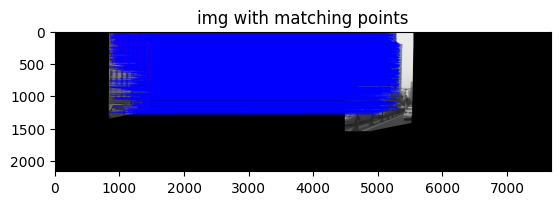

In [212]:
label = 3
maskall = stitcher.totalmask
target_masked = domask(stitcher.target, maskall==label)
reference_mask, reference_masked = ray_mask(stitcher.target, maskall==label)
src_pts, dst_pts, match_count = stitcher.sift_match(target_masked, reference_mask, stitcher.reference_nums[0])
drawMatches(imgs=[target_masked, reference_masked],src_pts=src_pts, dst_pts=dst_pts )

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


TypeError: Invalid shape (2, 2160, 3840) for image data

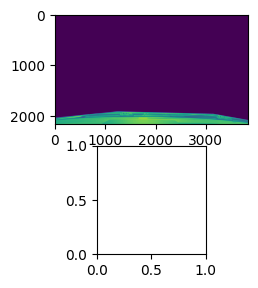

In [213]:
label = 8
print( stitcher.warpdict[label]['backward']['H'], stitcher.warpdict[label]['forward']['H'],)
plt.subplot(321)
plt.imshow(domask(stitcher.target, stitcher.warpdict[label]['backward']['mask']))
plt.subplot(323)
# plt.imshow(stitcher.warpdict[label]['backward']['reference'])
plt.imshow(ray_mask(stitcher.warpdict[label]['backward']['reference'],stitcher.warpdict[label]['backward']['mask']))
plt.subplot(324)
plt.imshow(stitcher.warp(stitcher.warpdict[label])[0])
plt.subplot(325)
plt.imshow(ray_mask(stitcher.warpdict[label]['forward']['reference'],stitcher.warpdict[label]['forward']['mask']))
# plt.imshow(stitcher.warpdict[label]['forward']['reference'])
plt.subplot(326)
plt.imshow(stitcher.warp(stitcher.warpdict[label])[1])
